# Proyecto de Consultoría – Clustering (Lab 12)
- Sofia Mishell 22049
- Jose Marchena 22398


### 0) Inicialización de Spark


In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Proyecto Consultoria Clustering - EDA") \
    .getOrCreate()

spark

### 1) Carga del Dataset

Cargamos el archivo `hack_data.csv`, que contiene información de las sesiones registradas durante los ataques.  
El parámetro `inferSchema=True` permite que Spark determine automáticamente los tipos de datos.

In [3]:
hack_df = spark.read.csv("data/hack_data.csv", header=True, inferSchema=True)

print(" Muestra de los datos:")
hack_df.show(5)


 Muestra de los datos:
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|
|                    2.0|           228.08|              1|             2.48|            8.0|             Bolivia|            70.8|
|                   20.0|            408.5|          

### 2) Análisis Exploratorio
#### Inspección General del dataset

In [4]:
print("Esquema del dataset:")
hack_df.printSchema()

print("\nNúmero de filas y columnas:")
print(f"Filas: {hack_df.count()}, Columnas: {len(hack_df.columns)}")

print("\nResumen estadístico:")
hack_df.describe().show()

# Verificar valores nulos
from pyspark.sql.functions import col, sum as _sum
hack_df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in hack_df.columns]).show()


Esquema del dataset:
root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)


Número de filas y columnas:
Filas: 334, Columnas: 7

Resumen estadístico:
+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|summary|Session_Connection_Time| Bytes Transferred|   Kali_Trace_Used|Servers_Corrupted|   Pages_Corrupted|   Location|  WPM_Typing_Speed|
+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|  count|                    334|               334|               334|              334|               334|        334|               334|
| 

##### Resultados
- **Filas:** 334  
- **Columnas:** 7  
- No hay valores nulos.  

**Tipos de datos:**
- `Session_Connection_Time`, `Bytes Transferred`, `Servers_Corrupted`, `Pages_Corrupted`, `WPM_Typing_Speed`: numéricos  
- `Kali_Trace_Used`: binario (0 = no, 1 = sí)  
- `Location`: categórica (texto)

**Estadísticas principales:**
| Variable | Media | Desv. Est. | Mín | Máx |
|-----------|-------|-------------|-----|-----|
| Session_Connection_Time | 30.0 | 14.09 | 1 | 60 |
| Bytes_Transferred | 607.2 | 286.3 | 10 | 1330 |
| Servers_Corrupted | 5.26 | 2.30 | 1 | 10 |
| Pages_Corrupted | 10.83 | 3.06 | 6 | 15 |
| WPM_Typing_Speed | 57.34 | 13.41 | 40 | 75 |

Los datos se distribuyen en rangos amplios, lo que sugiere comportamientos diversos en las sesiones.

#### Distribuciones númericas

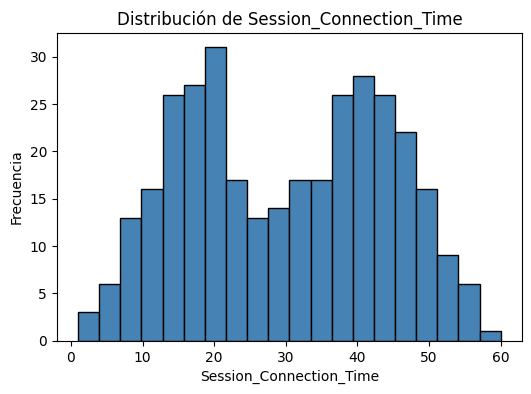

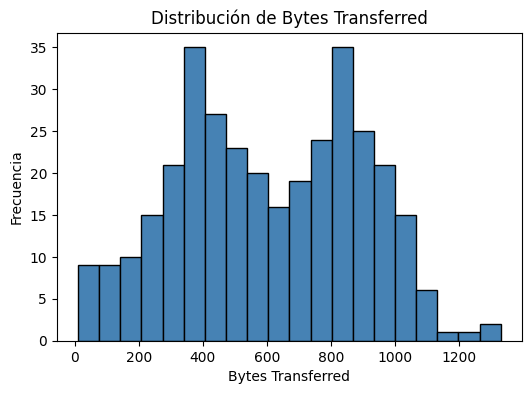

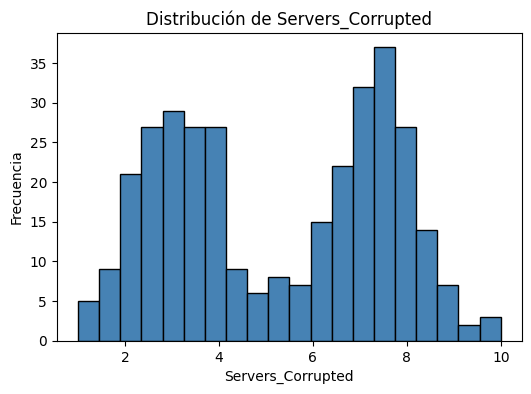

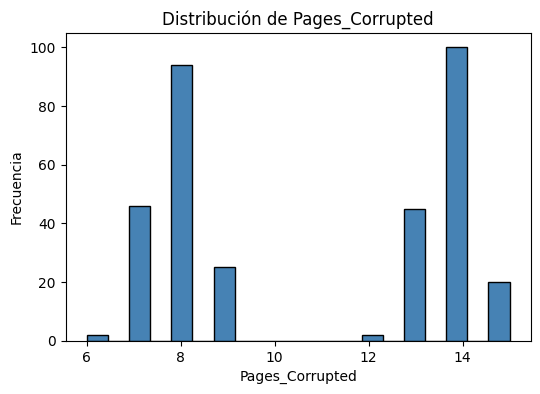

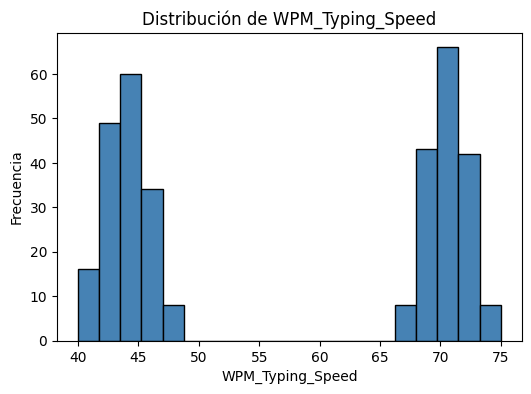

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

hack_pd = hack_df.toPandas()
num_cols = ['Session_Connection_Time','Bytes Transferred','Servers_Corrupted','Pages_Corrupted','WPM_Typing_Speed']

for col_name in num_cols:
    plt.figure(figsize=(6,4))
    plt.hist(hack_pd[col_name], bins=20, color='steelblue', edgecolor='black')
    plt.title(f'Distribución de {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Frecuencia')
    plt.show()

##### Interpretación

**Session_Connection_Time:**  
Muestra dos concentraciones principales, una entre 10–25 minutos y otra entre 35–50 minutos. Esto sugiere **dos grupos distintos de comportamiento** (posibles hackers con diferentes hábitos de conexión).

**Bytes_Transferred:**  
Presenta también dos picos, uno alrededor de 400 MB y otro cerca de 800 MB, reforzando la posibilidad de múltiples grupos de ataque con distinta intensidad de transferencia.

**Servers_Corrupted:**  
Tiene dos acumulaciones en torno a 3 y 7 servidores comprometidos. Esto indica dos niveles de agresividad en los ataques.

**Pages_Corrupted:**  
Los valores se agrupan fuertemente alrededor de 8 y 14 páginas afectadas, lo que sugiere que los atacantes tienden a causar un número específico de daños, probablemente por patrón de ejecución.

**WPM_Typing_Speed:**  
Muestra dos grupos bien definidos: uno entre 42–48 palabras por minuto y otro entre 68–72. Este indicador es muy relevante, pues **podría representar dos hackers distintos** según su velocidad de tecleo característica.


####  Análisis de Ubicaciones

In [7]:
loc_count = hack_df.groupBy("Location").count().orderBy("count", ascending=False)
loc_count.show(10)


+--------------------+-----+
|            Location|count|
+--------------------+-----+
|United States Vir...|    6|
|          Mauritania|    5|
|      Czech Republic|    5|
|       Guinea-Bissau|    5|
|             Reunion|    4|
|             Ukraine|    4|
|           Sri Lanka|    4|
|              Tuvalu|    4|
|Palestinian Terri...|    4|
|    Saint Barthelemy|    4|
+--------------------+-----+
only showing top 10 rows


Los ataques provienen de países muy diversos y con baja repetición, lo que confirma que los hackers utilizaron **VPNs o IPs falsas** para ocultar su origen.  
Por ello, `Location` **no es una variable confiable** para el clustering.

#### Matriz de Correlación

Analizamos la relación entre las variables numéricas para entender qué métricas se asocian entre sí.

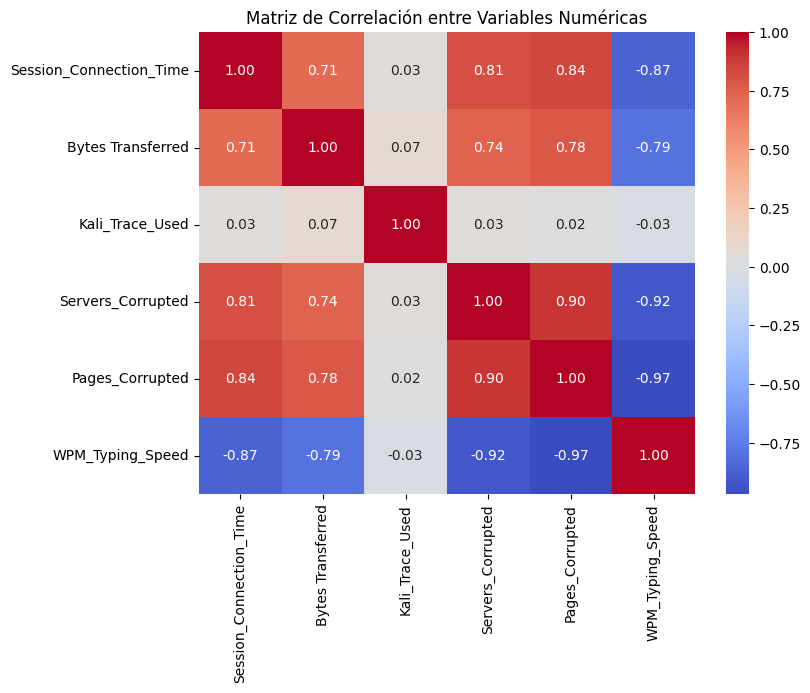

In [9]:
import seaborn as sns

corr = hack_pd.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.show()


##### Interpretación de la Matriz de Correlación

- **Servers_Corrupted** y **Pages_Corrupted** presentan una **correlación positiva muy alta (0.90)**, lo que indica que cuando se afectan más servidores también se corrompen más páginas.  
- **Session_Connection_Time**, **Bytes_Transferred** y las variables de daño muestran **correlaciones positivas fuertes**, reflejando que las sesiones más largas y con mayor transferencia generan más afectaciones.  
- **WPM_Typing_Speed** tiene **correlaciones negativas altas** con el resto, especialmente con **Pages_Corrupted (-0.97)** y **Servers_Corrupted (-0.92)**, lo que sugiere **dos tipos de hackers**:  
  - unos más **lentos y destructivos**,  
  - y otros **rápidos pero menos dañinos**.  
- **Kali_Trace_Used** no guarda relación significativa con las demás variables.

### 3) Limpieza Preliminar

Eliminamos la variable `Location`, pues no aporta valor analítico confiable, y mantenemos solo las variables relevantes para el clustering.


In [8]:
hack_clean_df = hack_df.drop("Location")
hack_clean_df.show(5)


+-----------------------+-----------------+---------------+-----------------+---------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|           69.08|
|                   31.0|           356.32|              1|             3.71|            8.0|           70.58|
|                    2.0|           228.08|              1|             2.48|            8.0|            70.8|
|                   20.0|            408.5|              0|             3.57|            8.0|           71.28|
+-----------------------+-----------------+---------------+-----------------+---------------+----------------+
o

### 4) Preparación de Datos y Clustering (K-Means con Spark)

Aplicar **K-Means** para identificar grupos naturales en los datos. El objetivo es determinar si los ataques se agrupan en **2 o 3 clusters**, lo cual ayudaría a inferir si hubo **dos o tres hackers** distintos.


In [10]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Ensamblamos las columnas numéricas relevantes en un solo vector
feature_cols = ['Session_Connection_Time', 'Bytes Transferred', 'Kali_Trace_Used',
                'Servers_Corrupted', 'Pages_Corrupted', 'WPM_Typing_Speed']

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features_unscaled')
assembled_df = assembler.transform(hack_clean_df)

# Escalamos los datos para que todas las variables contribuyan por igual
scaler = StandardScaler(inputCol='features_unscaled', outputCol='features', withMean=True, withStd=True)
scaled_df = scaler.fit(assembled_df).transform(assembled_df)

scaled_df.select('features').show(5, truncate=False)


+------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                |
+------------------------------------------------------------------------------------------------------------------------+
|[-1.562228040184432,-0.75490095925522,0.9748653409721156,-0.9985212523861794,-1.2529101889070722,1.1205379005060365]    |
|[-0.7104514131868532,0.3972422527942127,-1.0227114926762684,-0.9637674581126887,-0.6000677503813903,0.8752180545239784] |
|[0.07034382822759382,-0.8763317548992295,0.9748653409721156,-0.6727044310722048,-0.9264889696442312,0.9870660086191414] |
|[-1.9881163536832211,-1.3241973066216277,0.9748653409721156,-1.2070440180271231,-0.9264889696442312,1.0034703752197651] |
|[-0.7104514131868532,-0.6940982513989585,-1.0227114926762684,-0.7335235710508134,-0.9264889696442312,1.0392617205302177]|
+---------------

### 5) Aplicación del Modelo K-Means

In [11]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Modelo con 2 clusters
kmeans_2 = KMeans(featuresCol='features', k=2, seed=42)
model_2 = kmeans_2.fit(scaled_df)
pred_2 = model_2.transform(scaled_df)

# Modelo con 3 clusters
kmeans_3 = KMeans(featuresCol='features', k=3, seed=42)
model_3 = kmeans_3.fit(scaled_df)
pred_3 = model_3.transform(scaled_df)

# Evaluación con Silhouette Score
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette')

score_2 = evaluator.evaluate(pred_2)
score_3 = evaluator.evaluate(pred_3)

print(f"Silhouette Score (k=2): {score_2:.4f}")
print(f"Silhouette Score (k=3): {score_3:.4f}")


Silhouette Score (k=2): 0.8176
Silhouette Score (k=3): 0.7608


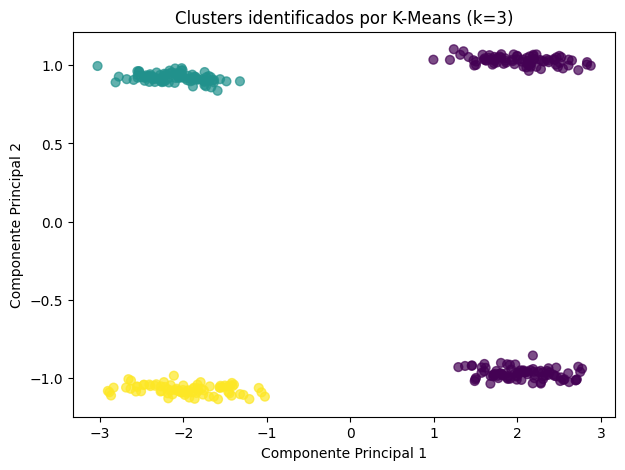

In [12]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

# Aplicamos PCA para reducir de 6D a 2D
pca = PCA(k=2, inputCol='features', outputCol='pca_features')
pca_model = pca.fit(scaled_df)
pca_df = pca_model.transform(pred_3)  # graficaremos el modelo con k=3

# Convertimos a Pandas para graficar
pca_pd = pca_df.select('pca_features', 'prediction').toPandas()
pca_pd[['x','y']] = pd.DataFrame(pca_pd['pca_features'].tolist(), index=pca_pd.index)

plt.figure(figsize=(7,5))
plt.scatter(pca_pd['x'], pca_pd['y'], c=pca_pd['prediction'], cmap='viridis', s=40, alpha=0.7)
plt.title('Clusters identificados por K-Means (k=3)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()
